In [50]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier

In [51]:
FOLDER_NAME = "../data"

validation_X = pd.read_csv(os.path.join(FOLDER_NAME, "test.csv"))
X = pd.read_csv(os.path.join(FOLDER_NAME, "train.csv"))

# Drop useless cols
drop_cols = ["Name", "PassengerId"]
validation_X = validation_X.drop(columns=drop_cols)
X = X.drop(columns=drop_cols)

X

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,211536,13.0000,NaN,S
887,1,1,female,19.0,0,0,112053,30.0000,B42,S
888,0,3,female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,1,1,male,26.0,0,0,111369,30.0000,C148,C


In [52]:
print(f'Train dataset has {X.shape[0]} rows and {X.shape[1]} columns.')
print(f'Test dataset has {validation_X.shape[0]} rows and {validation_X.shape[1]} columns.')

Train dataset has 891 rows and 10 columns.
Test dataset has 418 rows and 9 columns.


In [53]:
print(X.isna().sum() / X.shape[0])
print("-" * 25)
print(validation_X.isna().sum() / validation_X.shape[0])

Survived    0.000000
Pclass      0.000000
Sex         0.000000
Age         0.198653
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.000000
Cabin       0.771044
Embarked    0.002245
dtype: float64
-------------------------
Pclass      0.000000
Sex         0.000000
Age         0.205742
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.002392
Cabin       0.782297
Embarked    0.000000
dtype: float64


Most columns are full and both test and train datasets have same distribution of NaN values.

In [54]:
X.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


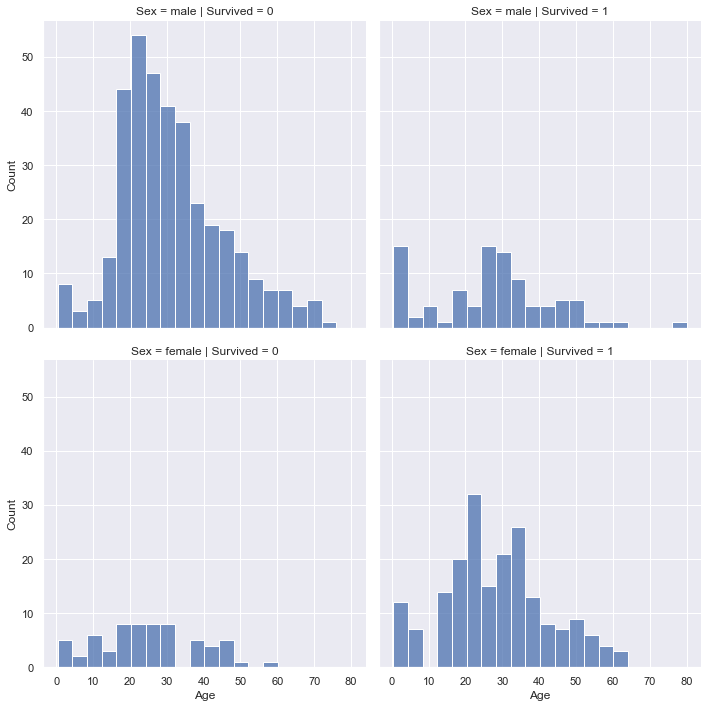

In [55]:
# Lets explore the data
sns.set_theme(style="darkgrid")
sns.displot(X, x="Age", col="Survived", row="Sex")

As you can see females were more likely to survive rather than males from titanic

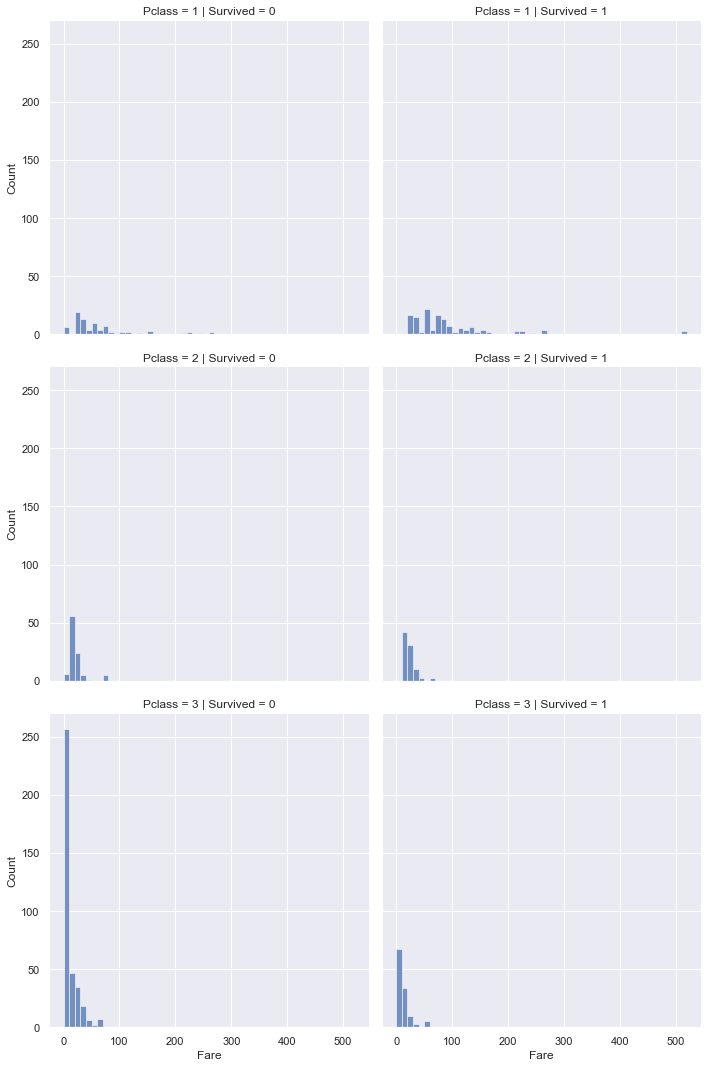

In [56]:
sns.displot(X, x="Fare", col="Survived", row="Pclass", binwidth=10)

Looks like the kids didnt survive the titanic either

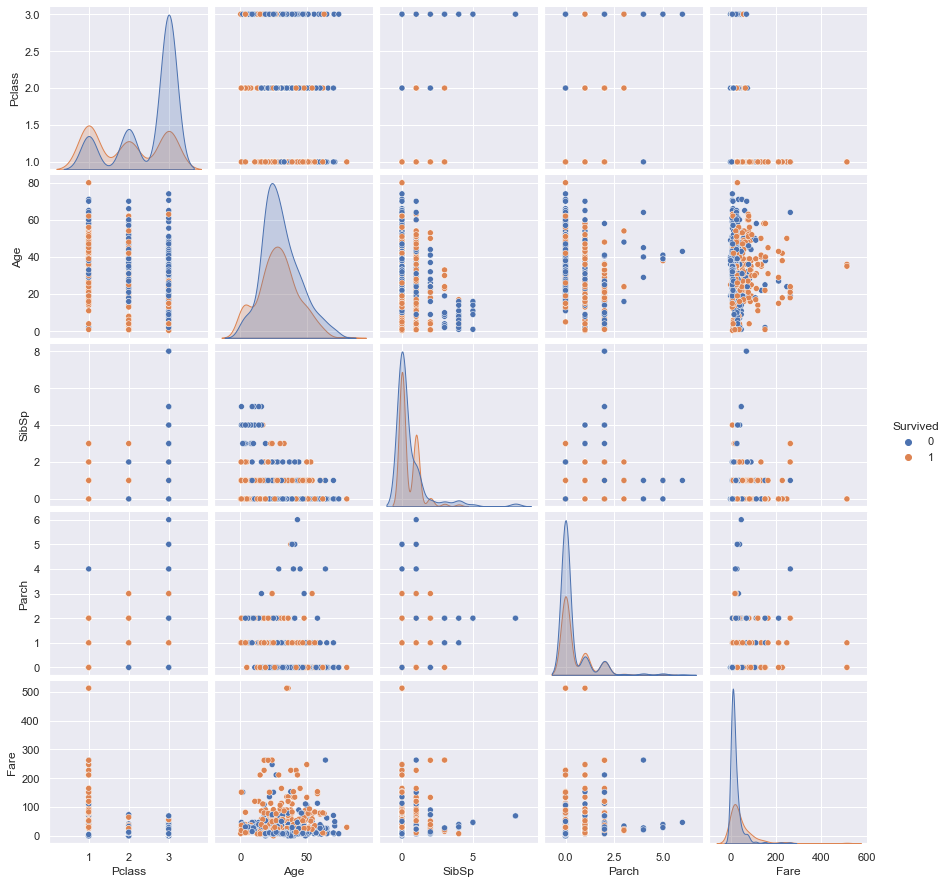

In [57]:
 g = sns.pairplot(X, hue="Survived")
 del g

In [58]:
Y = X["Survived"]
X = X.drop(columns="Survived")
X

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,female,35.0,1,0,113803,53.1000,C123,S
4,3,male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,211536,13.0000,NaN,S
887,1,female,19.0,0,0,112053,30.0000,B42,S
888,3,female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,1,male,26.0,0,0,111369,30.0000,C148,C


In [59]:
print(Y.value_counts())

0    549
1    342
Name: Survived, dtype: int64


Dataset is not horribly imbalanced

In [60]:
# Lets break the data into 10-fold sets

skf = StratifiedKFold(n_splits=10)
X_train_sets, X_test_sets = [], []
Y_train_sets, Y_test_sets = [], []
for train_idx, test_idx in skf.split(X, Y):
    X_train_sets.append(X.loc[train_idx, :].reset_index(drop=True))
    Y_train_sets.append(Y.loc[train_idx].reset_index(drop=True))
    X_test_sets.append(X.loc[test_idx, :].reset_index(drop=True))
    Y_test_sets.append(Y.loc[test_idx].reset_index(drop=True))

del skf


In [61]:
# Lets binary encode the sex values

for i, (train_X, test_X) in enumerate(zip(X_train_sets, X_test_sets)):
    label_encoder = LabelEncoder().fit(train_X["Sex"])
    train_X["SexEnc"] = label_encoder.transform(train_X["Sex"])
    # train_X = train_X.drop(columns="Sex")
    test_X["SexEnc"] = label_encoder.transform(test_X["Sex"])
    # test_X = test_X.drop(columns="Sex")

    X_train_sets[i] = train_X
    X_test_sets[i] = test_X

del label_encoder
X_train_sets[2]

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SexEnc
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,1,female,35.0,1,0,113803,53.1000,C123,S,0
4,3,male,35.0,0,0,373450,8.0500,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...
797,2,male,27.0,0,0,211536,13.0000,NaN,S,1
798,1,female,19.0,0,0,112053,30.0000,B42,S,0
799,3,female,NaN,1,2,W./C. 6607,23.4500,NaN,S,0
800,1,male,26.0,0,0,111369,30.0000,C148,C,1


In [62]:
print(f"There are {train_X['Embarked'].isna().sum()} NaN values in train_X['Embarked']")


There are 1 NaN values in train_X['Embarked']


Let us convert NaN to most frequent value for "Embarked" since it is 2/890 which is insignificant. Then we can one-hot encode the "Embarked" value.

In [63]:

def onehot_encode_embarked(train_X, test_X):
    values = np.array([["S"], ["C"], ["Q"]])

    train_embarked = train_X["Embarked"].to_numpy().reshape(-1, 1)
    test_embarked = test_X["Embarked"].to_numpy().reshape(-1, 1)

    imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    train_embarked = imputer.fit_transform(train_embarked)
    test_embarked = imputer.transform(test_embarked)

    onehot_encoder = OneHotEncoder(sparse=False).fit(values)
    train_embarked_enc = onehot_encoder.transform(train_embarked)
    test_embarked_enc = onehot_encoder.transform(test_embarked)

    # Sanity check to see that data is encoded the same way in test and train
    print(test_embarked_enc[0], test_embarked[0])
    print(train_embarked_enc[0], train_embarked[0])
    categories = [f"Embarked_{c}" for c in onehot_encoder.categories_[0]]

    train_emb_df = pd.DataFrame(data=train_embarked_enc, columns=categories)
    test_emb_df = pd.DataFrame(data=test_embarked_enc, columns=categories)

    # Lets leave Embarked_Q as that value is already encoded implicity. It adds no new information

    train_X["Embarked_S"] = train_emb_df["Embarked_S"]
    test_X["Embarked_S"] = test_emb_df["Embarked_S"]
    train_X["Embarked_C"] = train_emb_df["Embarked_C"]
    test_X["Embarked_C"] = test_emb_df["Embarked_C"]

    return train_X, test_X

for i, (train_X, test_X) in enumerate(zip(X_train_sets, X_test_sets)):
    train_X, test_X = onehot_encode_embarked(train_X, test_X)
    X_train_sets[i] = train_X
    X_test_sets[i] = test_X

X_test_sets[0]

[0. 0. 1.] ['S']
[0. 1. 0.] ['Q']
[0. 1. 0.] ['Q']
[0. 0. 1.] ['S']
[0. 0. 1.] ['S']
[0. 0. 1.] ['S']
[0. 0. 1.] ['S']
[0. 0. 1.] ['S']
[0. 0. 1.] ['S']
[0. 0. 1.] ['S']
[0. 0. 1.] ['S']
[0. 0. 1.] ['S']
[0. 0. 1.] ['S']
[0. 0. 1.] ['S']
[1. 0. 0.] ['C']
[0. 0. 1.] ['S']
[0. 0. 1.] ['S']
[0. 0. 1.] ['S']
[0. 0. 1.] ['S']
[0. 0. 1.] ['S']


,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SexEnc,Embarked_S,Embarked_C
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,1.0,0.0
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,0,0.0,1.0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1.0,0.0
3,1,female,35.0,1,0,113803,53.1000,C123,S,0,1.0,0.0
4,3,male,35.0,0,0,373450,8.0500,NaN,S,1,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
85,3,male,24.0,0,0,343275,8.0500,NaN,S,1,1.0,0.0
86,3,male,29.0,0,0,343276,8.0500,NaN,S,1,1.0,0.0
87,3,male,20.0,0,0,347466,7.8542,NaN,S,1,1.0,0.0
88,1,male,46.0,1,0,W.E.P. 5734,61.1750,E31,S,1,1.0,0.0


In [64]:
print(f"There are {train_X['Age'].isna().sum()} NaN values in train_X[Age]")
print(f"There are {train_X['Fare'].isna().sum()} NaN values in train_X[Fare]")
print(f"The mean for SexEnc == 1 is {train_X[train_X['SexEnc'] == 1]['Age'].mean()}")
print(f"The mean for SexEnc == 0 is {train_X[train_X['SexEnc'] == 0]['Age'].mean()}")

There are 163 NaN values in train_X[Age]
There are 0 NaN values in train_X[Fare]
The mean for SexEnc == 1 is 31.218476658476657
The mean for SexEnc == 0 is 27.564655172413794


Let us replace the missing ages with different means for males and females

In [65]:
for i, train_X in enumerate(X_train_sets):
    mask_1 = train_X['SexEnc'] == 1 & train_X['Age'].isna()
    train_X["Age"] = train_X["Age"].mask(cond=mask_1, 
                                        other=train_X[train_X['SexEnc'] == 1]['Age'].mean())

    mask_2 = train_X['SexEnc'] == 0 & train_X['Age'].isna()
    train_X["Age"] = train_X["Age"].mask(cond=mask_2, 
                                     other=train_X[train_X['SexEnc'] == 0]['Age'].mean())

    X_train_sets[i] = train_X

print(f"There are {train_X['Age'].isna().sum()} NaN values in train_X[Age]")
train_X

There are 0 NaN values in train_X[Age]


,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SexEnc,Embarked_S,Embarked_C
0,3,male,22.000000,1,0,A/5 21171,7.2500,NaN,S,1,1.0,0.0
1,1,female,31.218477,1,0,PC 17599,71.2833,C85,C,0,0.0,1.0
2,3,female,31.218477,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1.0,0.0
3,1,female,31.218477,1,0,113803,53.1000,C123,S,0,1.0,0.0
4,3,male,35.000000,0,0,373450,8.0500,NaN,S,1,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
797,3,male,30.000000,0,0,2685,7.2292,NaN,C,1,0.0,1.0
798,3,female,31.218477,1,1,345773,24.1500,NaN,S,0,1.0,0.0
799,2,male,34.000000,0,0,250647,13.0000,NaN,S,1,1.0,0.0
800,3,male,31.000000,0,0,347063,7.7750,NaN,S,1,1.0,0.0


In [66]:
# Let us do the same calc for test set
for i, test_X in enumerate(X_test_sets):
    mask_1 = test_X['SexEnc'] == 1 & test_X['Age'].isna()
    test_X["Age"] = test_X["Age"].mask(cond=mask_1, 
                                       other=test_X[test_X['SexEnc'] == 1]['Age'].mean())

    mask_2 = test_X['SexEnc'] == 0 & test_X['Age'].isna()
    test_X["Age"] = test_X["Age"].mask(cond=mask_2, 
                                       other=test_X[test_X['SexEnc'] == 0]['Age'].mean())

    X_test_sets[i] = test_X

print(f"There are {test_X['Age'].isna().sum()} NaN values in test_X[Age]")
test_X

There are 0 NaN values in test_X[Age]


,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SexEnc,Embarked_S,Embarked_C
0,3,female,26.375,0,0,349244,8.6833,NaN,S,0,1.0,0.0
1,2,female,26.375,1,1,C.A. 31921,26.2500,NaN,S,0,1.0,0.0
2,1,male,11.000,1,2,113760,120.0000,B96 B98,S,1,1.0,0.0
3,3,male,0.420,0,1,2625,8.5167,NaN,C,1,0.0,1.0
4,3,male,27.000,0,0,347089,6.9750,NaN,S,1,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
84,2,male,27.000,0,0,211536,13.0000,NaN,S,1,1.0,0.0
85,1,female,26.375,0,0,112053,30.0000,B42,S,0,1.0,0.0
86,3,female,26.375,1,2,W./C. 6607,23.4500,NaN,S,0,1.0,0.0
87,1,male,26.000,0,0,111369,30.0000,C148,C,1,0.0,1.0


In [67]:
print(f"There are {train_X['Ticket'].nunique()} unique values in Ticket column in train")
print(f"There are {test_X['Ticket'].nunique()} unique values in Ticket column in test")

There are 626 unique values in Ticket column in train
There are 85 unique values in Ticket column in test


One-hot/base-k style encoding it would make the number of features very high. This would impact our ML performance. This would be the perfect candidate for Target Encoding. 

Read this [blog](https://maxhalford.github.io/blog/target-encoding/) to get a better understanding.

In [68]:
def smooth_mean(train_X, train_Y, test_X, m):
    temp = pd.concat([train_X, train_Y], axis=1)

    # Prior survival prob
    prior = temp["Survived"].mean()

    # Compute the number of values and the mean of each group
    train_agg = temp.groupby("Ticket")["Survived"].agg(['count', 'mean'])
    counts = train_agg['count']
    means = train_agg['mean']

    # Compute the "smoothed" means for train dataset
    smooth = (counts * means + m * prior) / (counts + m)

    # Replace each value by the according smoothed mean in train
    # and test
    train_X["Ticket_enc"] = temp["Ticket"].map(smooth)
    test_X["Ticket_enc"] = test_X["Ticket"].map(smooth).fillna(prior)

    return train_X, test_X

for i, (train_X, train_Y, test_X) in enumerate(zip(X_train_sets, Y_train_sets, X_test_sets)):
    train_X, test_X = smooth_mean(train_X, train_Y, test_X, 200)
    
train_X

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SexEnc,Embarked_S,Embarked_C,Ticket_enc
0,3,male,22.000000,1,0,A/5 21171,7.2500,NaN,S,1,1.0,0.0,0.380889
1,1,female,31.218477,1,0,PC 17599,71.2833,C85,C,0,0.0,1.0,0.385864
2,3,female,31.218477,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1.0,0.0,0.385864
3,1,female,31.218477,1,0,113803,53.1000,C123,S,0,1.0,0.0,0.383953
4,3,male,35.000000,0,0,373450,8.0500,NaN,S,1,1.0,0.0,0.380889
...,...,...,...,...,...,...,...,...,...,...,...,...,...
797,3,male,30.000000,0,0,2685,7.2292,NaN,C,1,0.0,1.0,0.380889
798,3,female,31.218477,1,1,345773,24.1500,NaN,S,0,1.0,0.0,0.377136
799,2,male,34.000000,0,0,250647,13.0000,NaN,S,1,1.0,0.0,0.379003
800,3,male,31.000000,0,0,347063,7.7750,NaN,S,1,1.0,0.0,0.380889


In [69]:
for i, (train_X, test_X) in enumerate(zip(X_train_sets, X_test_sets)):

    # Let's drop the Cabin column since more than 70% of it is NaN anyway
    train_X = train_X.drop(columns="Cabin")
    test_X = test_X.drop(columns="Cabin")

    # Lets also impute missing fares
    def impute_fares(train_X, test_X):
        train_fare = train_X["Fare"].to_numpy().reshape(-1, 1)
        test_fare = test_X["Fare"].to_numpy().reshape(-1, 1)

        imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
        imputer.fit(train_fare)
        train_fare = imputer.transform(train_fare)
        test_fare = imputer.transform(test_fare)

        train_fare_df = pd.DataFrame(data=train_fare, columns=["Fare"])
        test_fare_df = pd.DataFrame(data=test_fare, columns=["Fare"])

        train_X["Fare_enc"] = train_fare_df["Fare"]
        test_X["Fare_enc"] = test_fare_df["Fare"]

        return train_X, test_X
        
    train_X, test_X = impute_fares(train_X, test_X)
    X_train_sets[i] = train_X
    X_test_sets[i] = test_X

print(train_X.isna().sum())
print(test_X.isna().sum())

Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Embarked      1
SexEnc        0
Embarked_S    0
Embarked_C    0
Ticket_enc    0
Fare_enc      0
dtype: int64
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Embarked      1
SexEnc        0
Embarked_S    0
Embarked_C    0
Ticket_enc    0
Fare_enc      0
dtype: int64


In [70]:
# Lets drop the columns that we have already encoded to another form

for i, (train_X, test_X) in enumerate(zip(X_train_sets, X_test_sets)):
    X_train_sets[i] = train_X.drop(columns=["Embarked", "Sex", "Ticket", "Fare"])
    X_test_sets[i] = test_X.drop(columns=["Embarked", "Sex", "Ticket", "Fare"])

X_train_sets[1]


,Pclass,Age,SibSp,Parch,SexEnc,Embarked_S,Embarked_C,Ticket_enc,Fare_enc
0,3,22.000000,1,0,1,1.0,0.0,0.382129,7.2500
1,1,30.688842,1,0,0,0.0,1.0,0.387104,71.2833
2,3,30.688842,0,0,0,1.0,0.0,0.387104,7.9250
3,1,30.688842,1,0,0,1.0,0.0,0.387104,53.1000
4,3,35.000000,0,0,1,1.0,0.0,0.382129,8.0500
...,...,...,...,...,...,...,...,...,...
797,2,27.000000,0,0,1,1.0,0.0,0.382129,13.0000
798,1,30.688842,0,0,0,1.0,0.0,0.387104,30.0000
799,3,30.688842,1,2,0,1.0,0.0,0.380238,23.4500
800,1,26.000000,0,0,1,0.0,1.0,0.387104,30.0000


In [71]:
# Let us standardize the inputs now
from sklearn.preprocessing import MinMaxScaler

for i, (train_X, test_X) in enumerate(zip(X_train_sets, X_test_sets)):
    scaler = MinMaxScaler()
    scaler.fit(train_X)
    X_train_sets[i] = pd.DataFrame(data=scaler.transform(train_X), columns=train_X.columns)
    X_test_sets[i] = pd.DataFrame(data=scaler.transform(test_X), columns=test_X.columns) 

X_train_sets[2]

,Pclass,Age,SibSp,Parch,SexEnc,Embarked_S,Embarked_C,Ticket_enc,Fare_enc
0,1.0,0.271174,0.125,0.000000,1.0,1.0,0.0,0.424814,0.014151
1,0.0,0.381334,0.125,0.000000,0.0,0.0,1.0,0.615629,0.139136
2,1.0,0.381334,0.000,0.000000,0.0,1.0,0.0,0.615629,0.015469
3,0.0,0.381334,0.125,0.000000,0.0,1.0,0.0,0.542129,0.103644
4,1.0,0.434531,0.000,0.000000,1.0,1.0,0.0,0.424814,0.015713
...,...,...,...,...,...,...,...,...,...
797,0.5,0.334004,0.000,0.000000,1.0,1.0,0.0,0.424814,0.025374
798,0.0,0.381334,0.000,0.000000,0.0,1.0,0.0,0.615629,0.058556
799,1.0,0.381334,0.125,0.333333,0.0,1.0,0.0,0.352259,0.045771
800,0.0,0.321438,0.000,0.000000,1.0,0.0,1.0,0.615629,0.058556


In [72]:
from sklearn.metrics import accuracy_score, f1_score


accuracies, f1_scores = [], []
for train_X, train_Y, test_X, test_Y in zip(X_train_sets, Y_train_sets, X_test_sets, Y_test_sets):
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(train_X, train_Y)

    Y_pred = clf.predict(test_X)
    accuracies.append(accuracy_score(test_Y, Y_pred))
    f1_scores.append(f1_score(test_Y, Y_pred))

accuracies = np.array(accuracies)
f1_scores = np.array(f1_scores)

print(f"Avg accuracy: {accuracies.mean()}")
print(f"Avg F1 scores: {f1_scores.mean()}")

Avg accuracy: 0.7406367041198502
Avg F1 scores: 0.6486105938703136
